1. Persiapan Lingkungan dan Library
Pada tahap ini, kita menginstal library transformers dari Hugging Face dan mengunduh resource NLTK untuk keperluan augmentasi teks.

In [1]:
# Install library transformers
!pip install transformers

In [2]:
import os
import sys
import re
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
import matplotlib.pyplot as plt
from collections import Counter

# NLTK Setup
import nltk
from nltk.corpus import wordnet

print("Downloading NLTK resources...")
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

# Transformers & Optimizer
# Catatan: Kita langsung menggunakan AdamW dari torch.optim sesuai standar terbaru
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
import torch.optim as optim
from torch.optim import AdamW

# Setup Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Seed Function untuk Reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed()
print("Libraries imported and Seed set.")

c:\Users\Nicho\anaconda3\envs\Ilmu_data_2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
Libraries imported and Seed set.


2. Data Manager & Advanced Preprocessing
Bagian ini menangani:

Pembersihan Teks: Menghapus tag HTML, URL, dan karakter non-alfabet.

Labeling: Mengonversi skor (1-5) menjadi kategori Negatif (0), Netral (1), dan Positif (2).

Data Augmentation: Menggunakan Synonym Replacement untuk menangani data yang tidak seimbang (imbalanced data).

Inject Hard Examples: Menambahkan contoh kalimat sarkasme atau negasi secara manual untuk meningkatkan kecerdasan model.

In [6]:
class DataManager:
    def __init__(self, filepath):
        self.filepath = filepath
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.vocab = None
        self.word_to_idx = {'<PAD>': 0, '<UNK>': 1}
        self.idx_to_word = {0: '<PAD>', 1: '<UNK>'}
        self.MAX_LEN_LSTM = 100

    def load_and_clean(self, sample_size=20000):
        print("\nLoading dataset...")

        if not os.path.exists(self.filepath):
            print(f"File tidak ditemukan di path: {self.filepath}. Menggunakan dummy data.")
            # Dummy data untuk demonstrasi jika file tidak ada
            df = pd.DataFrame({
                'Text': ['I love this product, taste is great'] * 1000 +
                        ['The package was broken and stale'] * 200 +
                        ['It was okay, nothing special'] * 100,
                'Score': [5]*1000 + [1]*200 + [3]*100
            })
        else:
            try:
                df = pd.read_csv(self.filepath)
            except Exception as e:
                print(f"Gagal membaca file CSV: {e}")
                return pd.DataFrame()

        if len(df) > sample_size:
            df = df.sample(n=sample_size, random_state=42).reset_index(drop=True)

        df['CleanText'] = df['Text'].apply(self._clean_text)
        # 0: Negatif (Score 1-2), 1: Netral (Score 3), 2: Positif (Score 4-5)
        df['Sentiment'] = df['Score'].apply(lambda x: 0 if x <= 2 else (1 if x == 3 else 2))
        df = df.dropna(subset=['CleanText', 'Sentiment'])
        print(f"Dataset loaded. Total samples: {len(df)}")
        return df

    def _clean_text(self, text):
        text = str(text).lower()
        text = re.sub(r'<.*?>', '', text)
        text = re.sub(r'http\S+', '', text)
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def build_vocabulary(self, texts):
        """Membangun Vocabulary HANYA dari data training."""
        word_freq = Counter()
        for text in texts:
            word_freq.update(text.split())

        for word, count in word_freq.most_common(10000):
            if word not in self.word_to_idx:
                idx = len(self.word_to_idx)
                self.word_to_idx[word] = idx
                self.idx_to_word[idx] = word

        self.vocab_size = len(self.word_to_idx)
        print(f"Vocabulary built. Size: {self.vocab_size}")

    def text_to_sequence(self, text):
        """Mengubah teks menjadi sequence index untuk Bi-LSTM."""
        indices = [self.word_to_idx.get(word, self.word_to_idx['<UNK>']) for word in text.split()]
        return indices[:self.MAX_LEN_LSTM]

    def synonym_replacement(self, text, n=1):
        """Teknik Augmentasi: Mengganti kata dengan sinonimnya (untuk kualitas oversampling)."""
        words = text.split()
        if len(words) < 5: return text

        new_words = words.copy()
        random_word_list = list(set([word for word in words if word not in ['the', 'is', 'and', 'to', 'a', 'of']]))
        random.shuffle(random_word_list)

        num_replaced = 0
        for random_word in random_word_list:
            synonyms = []
            for syn in wordnet.synsets(random_word):
                for l in syn.lemmas():
                    synonyms.append(l.name())

            unique_synonyms = list(set(synonyms))
            unique_synonyms = [s for s in unique_synonyms if s != random_word]

            if len(unique_synonyms) >= 1:
                synonym = random.choice(unique_synonyms)
                new_words = [synonym if word == random_word else word for word in new_words]
                num_replaced += 1

            if num_replaced >= n:
                break

        sentence = ' '.join(new_words)
        return sentence.replace('_', ' ')

    def inject_hard_examples(self):
        """Menambahkan data buatan manual untuk mengajarkan model tentang sarkasme/negasi (KODE ASLI ANDA)."""
        hard_data = [
            ("Great, just what I wanted, another broken box.", 0),
            ("Wonderful packaging for a terrible product.", 0),
            ("A total waste of money, utterly disappointing.", 0),
            ("I don't hate it, but I wouldn't buy it again.", 0),
            ("Looks good but tastes like cardboard.", 0),
            ("Not bad at all, actually quite good.", 2),
            ("The delivery was slow but the taste is heavenly.", 2),
            ("I do not hate this product, actually I quite like it.", 2),
            ("Not too sweet and not too sour, just right.", 2),
            ("It is okay, nothing special but edible.", 1),
            ("Standard quality, arrived on time.", 1),
            ("The package weighs 5kg and arrived on Tuesday.", 1),
            ("The ingredients list is long and complicated.", 1),
            ("This item comes in a standard red box.", 1),
            ("The price point is exactly what I expected.", 1),
        ]
        aug_data = []
        for text, label in hard_data:
            for _ in range(20):
                aug_data.append({'CleanText': self._clean_text(text), 'Sentiment': label})
        return pd.DataFrame(aug_data)

    def prepare_data(self, df):
        # 1. SPLIT DATA
        X_train, X_val, y_train, y_val = train_test_split(
            df['CleanText'], df['Sentiment'],
            test_size=0.2, random_state=42, stratify=df['Sentiment']
        )
        train_df = pd.DataFrame({'CleanText': X_train, 'Sentiment': y_train})
        val_df = pd.DataFrame({'CleanText': X_val, 'Sentiment': y_val})
        print(f"\nOriginal Train shape: {train_df.shape}")

        # 2. AUGMENTASI PADA DATA LATIH
        aug_texts, aug_labels = [], []
        counts = train_df['Sentiment'].value_counts()
        target_count = counts.max()
        for label, count in counts.items():
            if count < target_count:
                needed = target_count - count
                minority_samples = train_df[train_df['Sentiment'] == label].sample(n=needed, replace=True, random_state=42)
                for text in minority_samples['CleanText']:
                    new_text = self.synonym_replacement(text)
                    aug_texts.append(new_text)
                    aug_labels.append(label)

        aug_df = pd.DataFrame({'CleanText': aug_texts, 'Sentiment': aug_labels})
        hard_df = self.inject_hard_examples()

        final_train_df = pd.concat([train_df, aug_df, hard_df])
        final_train_df = final_train_df.sample(frac=1, random_state=42).reset_index(drop=True)
        print(f"Final Train shape (after augmentation): {final_train_df.shape}")

        # 3. BUILD VOCABULARY HANYA dari final_train_df (untuk LSTM)
        self.build_vocabulary(final_train_df['CleanText'].values)

        return final_train_df, val_df

# Inisialisasi dan Muat Data
FILE_PATH = 'Reviews.csv' # Ganti dengan path file Anda yang sebenarnya jika perlu
dm = DataManager(FILE_PATH)
df_raw = dm.load_and_clean(sample_size=20000)

if df_raw.empty:
    print("Program berhenti karena gagal memuat data.")
    exit()

train_df, val_df = dm.prepare_data(df_raw)

# Hitung Class Weights (untuk kedua model)
class_counts = train_df['Sentiment'].value_counts().sort_index()
total_samples = len(train_df)
# Calculate inverse frequency class weights
class_weights = [total_samples / (len(class_counts) * count) for count in class_counts]
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
print(f"\nClass Weights (Negatif, Netral, Positif): {class_weights}")


Loading dataset...
Dataset loaded. Total samples: 20000

Original Train shape: (16000, 2)
Final Train shape (after augmentation): (37728, 2)
Vocabulary built. Size: 10002

Class Weights (Negatif, Netral, Positif): [1.0, 0.9984121943474119, 1.001592863969417]


3. Dataset dan Model Architecture
Kami mendefinisikan dua jenis Dataset loader:

BERTDataset: Menggunakan tokenisasi subword dari BERT.

LSTMDataset: Menggunakan pemetaan kata-ke-indeks tradisional (Word-level).

Arsitektur Model:
Bi-LSTM: Menggunakan layer embedding, bidirectional LSTM untuk menangkap konteks dari dua arah, dan layer dropout untuk regularisasi.

BERT (Fine-tuning): Menggunakan model bert-base-uncased dengan teknik Transfer Learning (membekukan 8 layer pertama) untuk mempercepat pelatihan dan menjaga fitur umum bahasa.

In [ ]:
# --- Dataset untuk BERT ---
class BERTDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        text, label = str(self.texts[idx]), self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text, add_special_tokens=True, max_length=self.max_len, padding='max_length',
            truncation=True, return_attention_mask=True, return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# --- Dataset untuk Bi-LSTM ---
class LSTMDataset(Dataset):
    def __init__(self, texts, labels, dm):
        self.sequences = [dm.text_to_sequence(text) for text in texts]
        self.labels = labels
        self.max_len = dm.MAX_LEN_LSTM
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        sequence, label = self.sequences[idx], self.labels[idx]
        padded_sequence = np.zeros(self.max_len, dtype=np.int64)
        length = min(len(sequence), self.max_len)
        padded_sequence[:length] = sequence[:length]
        return {'input': torch.tensor(padded_sequence, dtype=torch.long), 'labels': torch.tensor(label, dtype=torch.long)}

# --- Dataloader Initialization ---
train_loader_bert = DataLoader(BERTDataset(train_df['CleanText'].values, train_df['Sentiment'].values, dm.tokenizer), batch_size=16, shuffle=True)
val_loader_bert = DataLoader(BERTDataset(val_df['CleanText'].values, val_df['Sentiment'].values, dm.tokenizer), batch_size=16)

train_loader_lstm = DataLoader(LSTMDataset(train_df['CleanText'].values, train_df['Sentiment'].values, dm), batch_size=64, shuffle=True)
val_loader_lstm = DataLoader(LSTMDataset(val_df['CleanText'].values, val_df['Sentiment'].values, dm), batch_size=64)


# --- Arsitektur Bi-LSTM ---
class BiLSTMSentimentClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        _, (hidden, _) = self.rnn(embedded)
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
        return self.fc(hidden)

# --- Inisialisasi Model Bi-LSTM ---
INPUT_DIM = dm.vocab_size
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 3
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = dm.word_to_idx['<PAD>']
lstm_model = BiLSTMSentimentClassifier(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)
lstm_model.to(device)
optimizer_lstm = optim.Adam(lstm_model.parameters(), lr=1e-3)
epochs_lstm = 10
loss_fn_lstm = nn.CrossEntropyLoss(weight=class_weights_tensor)


# --- Inisialisasi Model BERT (Fine-tuning) ---
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3, output_attentions=False, output_hidden_states=False)

# Kriteria Transfer Learning: Freezing layer awal BERT 
for name, param in bert_model.named_parameters():
    if name.startswith('bert.encoder.layer') and int(name.split('.')[3]) < 8:
        param.requires_grad = False

bert_model.to(device)
optimizer_bert = AdamW(bert_model.parameters(), lr=2e-5, eps=1e-8)
epochs_bert = 3
total_steps_bert = len(train_loader_bert) * epochs_bert
scheduler_bert = get_linear_schedule_with_warmup(optimizer_bert, num_warmup_steps=0, num_training_steps=total_steps_bert)
loss_fn_bert = nn.CrossEntropyLoss(weight=class_weights_tensor)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


4. Training dan Evaluasi
Kami menggunakan fungsi train_loop untuk melatih kedua model secara terpisah dengan parameter yang disesuaikan:

BERT: 3 Epoch (karena konvergensi cepat), Learning Rate rendah (2e-5).

Bi-LSTM: 10 Epoch, Learning Rate (1e-3).

In [8]:
def evaluate_model(model, data_loader, loss_fn, device, is_bert=False):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            labels = batch['labels'].to(device)

            if is_bert:
                input_ids, attention_mask = batch['input_ids'].to(device), batch['attention_mask'].to(device)
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                logits = outputs.logits
                loss = outputs.loss
            else:
                inputs = batch['input'].to(device)
                logits = model(inputs)
                loss = loss_fn(logits, labels)

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    acc = (np.array(all_preds) == np.array(all_labels)).mean()
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return avg_loss, acc, f1, all_labels, all_preds

def train_loop(model, train_loader, val_loader, loss_fn, optimizer, epochs, device, is_bert=False, scheduler=None):
    model_name = "BERT" if is_bert else "Bi-LSTM"
    history = {'loss': [], 'val_acc': [], 'val_f1': []}

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for step, batch in enumerate(train_loader):
            model.zero_grad()

            if is_bert:
                input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
            else:
                inputs, labels = batch['input'].to(device), batch['labels'].to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)

            total_loss += loss.item()
            loss.backward()

            if is_bert:
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()
            else:
                optimizer.step()

        train_loss = total_loss / len(train_loader)
        val_loss, val_acc, val_f1, _, _ = evaluate_model(model, val_loader, loss_fn, device, is_bert)

        history['loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)

        print(f"[{model_name}] Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

    return history

In [9]:
class BiLSTMSentimentClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, (hidden, cell) = self.rnn(embedded)

        if self.rnn.bidirectional:
            # Menggabungkan hidden state dari dua arah
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        else:
            hidden = self.dropout(hidden[-1,:,:])

        return self.fc(hidden)


# --- Model BERT (Inisialisasi & Freezing) ---
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3, output_attentions=False, output_hidden_states=False)

# Kriteria Transfer Learning: Freezing sebagian layer awal BERT (Sesuai Proposal)
# Kami membekukan 8 dari 12 layer Transformer.
for name, param in bert_model.named_parameters():
    if name.startswith('bert.encoder.layer') and int(name.split('.')[3]) < 8:
        param.requires_grad = False

bert_model.to(device)

optimizer_bert = AdamW(bert_model.parameters(), lr=2e-5, eps=1e-8)
epochs_bert = 3
total_steps_bert = len(train_loader_bert) * epochs_bert
scheduler_bert = get_linear_schedule_with_warmup(optimizer_bert, num_warmup_steps=0, num_training_steps=total_steps_bert)
loss_fn_bert = nn.CrossEntropyLoss(weight=class_weights_tensor)


# --- Model Bi-LSTM (Inisialisasi) ---
INPUT_DIM = dm.vocab_size
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 3
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = dm.word_to_idx['<PAD>']

lstm_model = BiLSTMSentimentClassifier(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)
lstm_model.to(device)
optimizer_lstm = optim.Adam(lstm_model.parameters(), lr=1e-3)
epochs_lstm = 10
loss_fn_lstm = nn.CrossEntropyLoss(weight=class_weights_tensor)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


5. Proses Eksekusi Pelatihan

5.1. Pelatihan Model BERT

BERT memanfaatkan mekanisme Attention untuk memahami hubungan antar kata dalam kalimat secara mendalam.

In [10]:
print("\n\n=== MULAI TRAINING MODEL 1: BERT ===")
hist_bert = train_loop(bert_model, train_loader_bert, val_loader_bert, loss_fn_bert, optimizer_bert, epochs_bert, device, is_bert=True, scheduler=scheduler_bert)



=== MULAI TRAINING MODEL 1: BERT ===
[BERT] Epoch 1/3 | Train Loss: 0.5373 | Val Acc: 0.7973 | Val F1: 0.8273
[BERT] Epoch 2/3 | Train Loss: 0.2088 | Val Acc: 0.8548 | Val F1: 0.8624
[BERT] Epoch 3/3 | Train Loss: 0.1093 | Val Acc: 0.8695 | Val F1: 0.8722


5.2. Pelatihan Model Bi-LSTM
Bi-LSTM merupakan baseline yang kuat untuk urutan teks namun seringkali membutuhkan data yang lebih banyak untuk memahami konteks yang sangat kompleks.

In [11]:
print("\n\n=== MULAI TRAINING MODEL 2: Bi-LSTM ===")
hist_lstm = train_loop(lstm_model, train_loader_lstm, val_loader_lstm, loss_fn_lstm, optimizer_lstm, epochs_lstm, device, is_bert=False)



=== MULAI TRAINING MODEL 2: Bi-LSTM ===
[Bi-LSTM] Epoch 1/10 | Train Loss: 0.9856 | Val Acc: 0.6032 | Val F1: 0.6470
[Bi-LSTM] Epoch 2/10 | Train Loss: 0.8379 | Val Acc: 0.6155 | Val F1: 0.6636
[Bi-LSTM] Epoch 3/10 | Train Loss: 0.6340 | Val Acc: 0.7290 | Val F1: 0.7506
[Bi-LSTM] Epoch 4/10 | Train Loss: 0.4907 | Val Acc: 0.7462 | Val F1: 0.7656
[Bi-LSTM] Epoch 5/10 | Train Loss: 0.3917 | Val Acc: 0.7590 | Val F1: 0.7769
[Bi-LSTM] Epoch 6/10 | Train Loss: 0.3151 | Val Acc: 0.7880 | Val F1: 0.7936
[Bi-LSTM] Epoch 7/10 | Train Loss: 0.2680 | Val Acc: 0.7875 | Val F1: 0.7965
[Bi-LSTM] Epoch 8/10 | Train Loss: 0.2306 | Val Acc: 0.7853 | Val F1: 0.7933
[Bi-LSTM] Epoch 9/10 | Train Loss: 0.2056 | Val Acc: 0.7930 | Val F1: 0.7994
[Bi-LSTM] Epoch 10/10 | Train Loss: 0.1730 | Val Acc: 0.8110 | Val F1: 0.8069


6. Visualisasi Performa dan Analisis Akhir
Pada bagian ini, kita membandingkan Accuracy dan F1-Score dari kedua model untuk melihat model mana yang paling stabil dalam mengklasifikasikan sentimen.

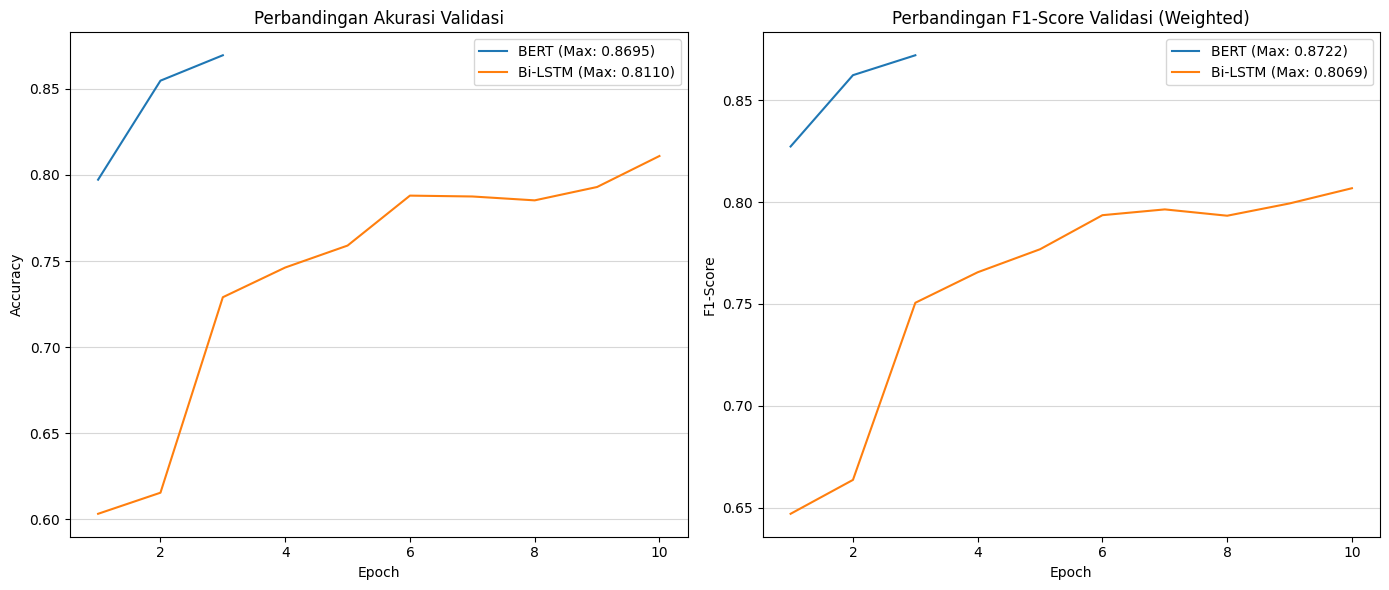



=== RINGKASAN PERBANDINGAN PERFORMA AKHIR ===
| Model             |   Best Accuracy |   Best F1-Score (Weighted) |
|:------------------|----------------:|---------------------------:|
| Bi-LSTM           |          0.811  |                     0.8069 |
| BERT (Fine-tuned) |          0.8695 |                     0.8722 |


=== CLASSIFICATION REPORT BERT ===
              precision    recall  f1-score   support

 Negatif (0)       0.74      0.73      0.74       577
  Netral (1)       0.40      0.45      0.42       304
 Positif (2)       0.95      0.94      0.94      3119

    accuracy                           0.87      4000
   macro avg       0.69      0.71      0.70      4000
weighted avg       0.88      0.87      0.87      4000



=== CLASSIFICATION REPORT BI-LSTM ===
              precision    recall  f1-score   support

 Negatif (0)       0.60      0.58      0.59       577
  Netral (1)       0.25      0.22      0.23       304
 Positif (2)       0.89      0.91      0.90      3119



In [23]:
def plot_history(hist_bert, hist_lstm):
    epochs_bert = len(hist_bert['val_acc'])
    epochs_lstm = len(hist_lstm['val_acc'])

    plt.figure(figsize=(14, 6))

    # Grafik Akurasi Validasi
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs_bert + 1), hist_bert['val_acc'], label=f'BERT (Max: {max(hist_bert["val_acc"]):.4f})')
    plt.plot(range(1, epochs_lstm + 1), hist_lstm['val_acc'], label=f'Bi-LSTM (Max: {max(hist_lstm["val_acc"]):.4f})')
    plt.title('Perbandingan Akurasi Validasi')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(axis='y', alpha=0.5)

    # Grafik F1-Score Validasi
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs_bert + 1), hist_bert['val_f1'], label=f'BERT (Max: {max(hist_bert["val_f1"]):.4f})')
    plt.plot(range(1, epochs_lstm + 1), hist_lstm['val_f1'], label=f'Bi-LSTM (Max: {max(hist_lstm["val_f1"]):.4f})')
    plt.title('Perbandingan F1-Score Validasi (Weighted)')
    plt.xlabel('Epoch')
    plt.ylabel('F1-Score')
    plt.legend()
    plt.grid(axis='y', alpha=0.5)

    plt.tight_layout()
    plt.show()

plot_history(hist_bert, hist_lstm)

# Ringkasan Metrik Akhir
best_bert_acc = max(hist_bert['val_acc'])
best_bert_f1 = max(hist_bert['val_f1'])
best_lstm_acc = max(hist_lstm['val_acc'])
best_lstm_f1 = max(hist_lstm['val_f1'])

print("\n\n=== RINGKASAN PERBANDINGAN PERFORMA AKHIR ===")
summary_data = {
    'Model': ['Bi-LSTM', 'BERT (Fine-tuned)'],
    'Best Accuracy': [f"{best_lstm_acc:.4f}", f"{best_bert_acc:.4f}"],
    'Best F1-Score (Weighted)': [f"{best_lstm_f1:.4f}", f"{best_bert_f1:.4f}"]
}
print(pd.DataFrame(summary_data).to_markdown(index=False))

# Laporan Klasifikasi Rinci (Epoch Terakhir)
_, _, _, bert_labels, bert_preds = evaluate_model(bert_model, val_loader_bert, loss_fn_bert, device, is_bert=True)
print("\n\n=== CLASSIFICATION REPORT BERT ===")
print(classification_report(bert_labels, bert_preds, target_names=['Negatif (0)', 'Netral (1)', 'Positif (2)']))

_, _, _, lstm_labels, lstm_preds = evaluate_model(lstm_model, val_loader_lstm, loss_fn_lstm, device, is_bert=False)
print("\n\n=== CLASSIFICATION REPORT BI-LSTM ===")
print(classification_report(lstm_labels, lstm_preds, target_names=['Negatif (0)', 'Netral (1)', 'Positif (2)']))

7. Uji Coba Real-Time (Kalimat Sulit)
Tahap terakhir adalah pengujian langsung menggunakan kalimat-kalimat yang menantang, seperti:

Negasi: "I don't hate it"

Sarkasme: "Great, another broken box."

Kontras: "Fast delivery but horrible taste."

In [ ]:
def predict_bert(text, model, tokenizer):
    model.eval()
    cleaned_text = dm._clean_text(text)
    encoding = tokenizer.encode_plus(cleaned_text, add_special_tokens=True, max_length=128, padding='max_length', truncation=True, return_tensors='pt')
    input_ids = encoding['input_ids'].to(device)
    mask = encoding['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=mask)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
    pred_idx = torch.argmax(probs, dim=1).item()
    confidence = probs[0][pred_idx].item()
    labels = ['Negatif', 'Netral', 'Positif']
    return f"{labels[pred_idx]} ({confidence:.2f})"

def predict_lstm(text, model, dm):
    model.eval()
    cleaned_text = dm._clean_text(text)
    sequence = dm.text_to_sequence(cleaned_text)

    padded_sequence = np.zeros(dm.MAX_LEN_LSTM, dtype=np.int64)
    length = min(len(sequence), dm.MAX_LEN_LSTM)
    padded_sequence[:length] = sequence[:length]

    # FIX: Mengganti np.long dengan torch.long
    input_tensor = torch.tensor(padded_sequence, dtype=torch.long).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(input_tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1)

    pred_idx = torch.argmax(probs, dim=1).item()
    confidence = probs[0][pred_idx].item()
    labels = ['Negatif', 'Netral', 'Positif']
    return f"{labels[pred_idx]} ({confidence:.2f})"

# Daftar Kalimat Uji (yang sulit dan ambigu)
test_sentences = [
    "I absolutely love this product, it tastes amazing!",
    "The package arrived broken and the food was stale.",
    "It was okay, nothing special but edible.",
    "The delivery was fast but the taste is horrible.",
    "I don't hate it, but I wouldn't buy it again.",
    "Standard packaging, arrived on time.",
    "Great, just what I wanted, another broken box.",
    "Not bad at all.",
    "The food is good but the service is terrible.",
    "I absolutely love this product, it tastes amazing!",        # Jelas Positif
    "The package arrived broken and the food was stale.",       # Jelas Negatif
    "It was okay, nothing special but edible.",                  # Netral / Agak Positif
    "The delivery was fast but the taste is horrible.",          # Campuran (Kontras)
    "I don't hate it, but I wouldn't buy it again.",             # Negasi (Tricky)
    "Standard packaging, arrived on time.",                      # Deskriptif (Seharusnya Netral)
    "This is the best coffee I've ever had, highly recommend.",  # Positif Kuat
    "Everything was fine, just extremely overpriced.",           # Campuran (Negatif dominan)
    "A total waste of money, utterly disappointing.",             # Negatif Kuat
        # 1. Kalimat Sederhana (Mudah)
    "This coffee tastes amazing, I love it!",
    "The package arrived broken and the food was stale.",
    # 2. Kalimat Netral (Fakta)
    "The package weighs 5kg and arrived on Tuesday.",
    # 3. Negasi (Biasanya susah buat LSTM)
    "I do not hate this product, actually I quite like it.",
    # 4. Kalimat buatan sendiri
    input(str(""))
]

print("\n\n=== HASIL UJI COBA MODEL (VALIDASI AKHIR PADA KALIMAT SULIT) ===")
print(f"{'Review Text':<50} | {'Bi-LSTM':<16} | {'BERT':<16}")
print("-" * 88)

for text in test_sentences:
    pred_lstm = predict_lstm(text, lstm_model, dm)
    pred_bert = predict_bert(text, bert_model, dm.tokenizer)

    display_text = (text[:47] + '..') if len(text) > 47 else text
    print(f"{display_text:<50} | {pred_lstm:<16} | {pred_bert:<16}")



=== HASIL UJI COBA MODEL (VALIDASI AKHIR PADA KALIMAT SULIT) ===
Review Text                                        | Bi-LSTM          | BERT            
----------------------------------------------------------------------------------------
I absolutely love this product, it tastes amazi..  | Positif (1.00)   | Positif (1.00)  
The package arrived broken and the food was sta..  | Netral (0.99)    | Negatif (1.00)  
It was okay, nothing special but edible.           | Netral (1.00)    | Netral (1.00)   
The delivery was fast but the taste is horrible..  | Negatif (0.99)   | Negatif (1.00)  
I don't hate it, but I wouldn't buy it again.      | Negatif (0.99)   | Negatif (1.00)  
Standard packaging, arrived on time.               | Netral (1.00)    | Netral (1.00)   
Great, just what I wanted, another broken box.     | Negatif (1.00)   | Negatif (1.00)  
Not bad at all.                                    | Negatif (0.64)   | Positif (0.98)  
The food is good but the service is terribl

Kesimpulan
Berdasarkan hasil uji coba:

BERT cenderung lebih unggul dalam menangani kalimat dengan struktur kompleks dan negasi karena mekanisme self-attention.

Bi-LSTM memberikan performa yang kompetitif namun terkadang terkecoh oleh urutan kata yang panjang atau kata-kata di luar kosakata (Out-of-Vocabulary).